# Challenge SD207 - 2017
*<p>Author: Pengfei MI, Rui SONG</p>*
*<p>Date: 06/06/2017</p>*

In [13]:
# Basic libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import platform
from time import time

# Librosa related: audio feature extraction
import librosa
import librosa.display

# Sklearn related: data preprocessing and classifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.base import clone
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.utils.estimator_checks import check_estimator
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import inspect
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

In [2]:
# Define some usefull functions
def cross_validation(clf, X, y, test_fold):
    y_pred, y_pred_sum, y_pred_prod = np.empty_like(y), np.empty_like(y), np.empty_like(y)
    n_folds = len(np.unique(test_fold))
    for i in range(n_folds):
        t0 = time()
        new_clf = clone(clf, safe=True)
        X_train = X[test_fold != i]
        X_test = X[test_fold == i]
        y_train = y[test_fold != i]
        y_test = y[test_fold == i]
        print "Launching fold #%d/%d, train set size: %d, test set size: %d" % (i+1, n_folds, len(X_train), len(X_test))
        new_clf.fit(X_train, y_train)
        test_pred = new_clf.predict(X_test, "maj")
        test_pred_sum = new_clf.predict(X_test, "sum")
        test_pred_prod = new_clf.predict(X_test, "prod")
        y_pred[test_fold == i] = test_pred
        y_pred_sum[test_fold == i] = test_pred_sum
        y_pred_prod[test_fold == i] = test_pred_prod
        print "fold#%d done in %0.3fs, score: %0.3f." % (i+1, time()-t0, accuracy_score(y_test, test_pred))
    t0 = time()
    print "Retraining classifier with whole train set..."
    clf.fit(X, y)
    print "Done in %0.3fs." % (time() - t0)
    return y_pred, y_pred_sum, y_pred_prod

class AcousticSceneClassifier(BaseEstimator, ClassifierMixin):
    """Classifier adapted to acoustic scene classification."""
    def __init__(self, base_estimator=MLPClassifier(), feature_type="mfcc", n_mfcc=20, n_fft=512, hop_length=512, width=3, n_fusion=-1):
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)
        self.features_ = {}
        self.clf_ = clone(base_estimator, safe=True)
        
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        self.features_ = {}
        return self
    
    def _extract_feature(self, file_name): # Late fusion
        if file_name not in self.features_:
            X, sample_rate = librosa.load(os.path.join(FILEROOT, file_name), sr=None)
            frame_mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_fft=self.n_fft, hop_length=self.hop_length, n_mfcc=self.n_mfcc).T
            if self.feature_type == 'mfcc':
                frame_feature = frame_mfcc
            elif self.feature_type == 'mfcc_0':
                frame_feature = frame_mfcc[:, 1:]
            elif self.feature_type == "d_mfcc":
                frame_feature = librosa.feature.delta(frame_mfcc, width=self.width, order=1, trim=True)
            elif self.feature_type == "dd_mfcc":
                frame_feature = librosa.feature.delta(frame_mfcc, width=self.width, order=2, trim=True)
            elif self.feature_type == "mfcc_d":
                d_mfcc = librosa.feature.delta(frame_mfcc, width=self.width, order=1, trim=True)
                frame_feature = np.c_[frame_mfcc, d_mfcc]
            elif self.feature_type == "hpss":
                H, P = librosa.effects.hpss(X)
                H_mfcc = librosa.feature.mfcc(y=H, sr=sample_rate, n_fft=self.n_fft, hop_length=self.hop_length, n_mfcc=self.n_mfcc).T
                P_mfcc = librosa.feature.mfcc(y=P, sr=sample_rate, n_fft=self.n_fft, hop_length=self.hop_length, n_mfcc=self.n_mfcc).T
                frame_feature = np.c_[H_mfcc, P_mfcc]
            elif self.feature_type == "mixed":
                d_mfcc = librosa.feature.delta(mfcc, width=self.width, order=1, trim=True)
                dd_mfcc = librosa.feature.delta(mfcc, width=self.width, order=2, trim=True)
                frame_feature = np.c_[mfcc, d_mfcc, dd_mfcc]
            else:
                d_mfcc = librosa.feature.delta(mfcc, width=self.width, order=1, trim=True)
                dd_mfcc = librosa.feature.delta(mfcc, width=self.width, order=2, trim=True)
                frame_feature = np.c_[mfcc, d_mfcc, dd_mfcc]

            if self.n_fusion == -1:
                self.features_[file_name] = frame_feature
            elif self.n_fusion == 0:
                self.features_[file_name] = np.mean(frame_feature, axis=0).reshape((1, -1))
            else:
                n_frames = frame_feature.shape[0]/self.n_fusion
                fusion_mean = np.empty((n_frames, frame_feature.shape[1]))
                #fusion_var = fusion_mean = np.empty((n_frames, frame_feature.shape[1]))
                for i in range(n_frames):
                    fusion_mean[i, :] = np.mean(frame_feature[self.n_fusion*i:self.n_fusion*(i+1)-1, :], axis=0)
                    #fusion_var[i, :] = np.std(frame_feature[n_fusion*i:n_fusion*(i+1)-1, :], axis=0)
                #return np.c_[fusion_mean, fusion_var]
                self.features_[file_name] = fusion_mean
        return self.features_[file_name]

    def _parse_audio_files(self, file_names, file_labels):
        # Try to detect the feature dimension
        n_features = self._extract_feature(file_names[0]).shape[1]
        features, labels = np.empty((0, n_features)), np.empty(0)
        for fn, fl in zip(file_names, file_labels):
            ff = self._extract_feature(fn)
            features = np.vstack([features, ff])
            labels = np.append(labels, fl*np.ones(ff.shape[0]))
        return np.array(features), np.array(labels, dtype = np.int)
    
    def fit(self, X, y):
        X_train, y_train= self._parse_audio_files(X, y)
        self.clf_.fit(X_train, y_train)
        return self
        
    def predict(self, X, rule="maj"):
        y_pred = np.empty(0)
        for x in X:
            x_feature = self._extract_feature(x)
            if rule == "maj":
                y_predicts = self.clf_.predict(x_feature)
                y_pred = np.append(y_pred, sp.stats.mode(y_predicts).mode[0])
            elif rule == "sum":
                y_predict_probas = self.clf_.predict_proba(x_feature)
                y_pred = np.append(y_pred, np.argmax(np.sum(y_predict_probas, axis=0)))
            else:
                y_predict_probas = self.clf_.predict_proba(x_feature)
                y_pred = np.append(y_pred, np.argmax(np.prod(y_predict_probas, axis=0)))
        return np.array(y_pred, dtype=np.int)

In [3]:
# Read data and preprocessing
print "Loading files..."
t0 = time()

# Define FILEROOT according to the platform
# My personal computer
if sys.platform == "darwin":
    FILEROOT = './'
# Node of Telecom
elif platform.node()[:4] == 'lame':
    FILEROOT = '/tmp/'
# The machines of Telecom
else:
    FILEROOT = '/tsi/plato/sons/sd207/'

# Load the cross validation folds
N_FOLDS = 3
train_files, train_scenes, test_fold = np.empty(0, dtype=str), np.empty(0), np.empty(0)
for i in range(N_FOLDS):
    files = pd.read_csv('train%s.txt' % str(i), sep='\s+', header=None)[0].values
    scenes = pd.read_csv('train%s.txt' % str(i), sep='\s+', header=None)[1].values
    print "Fold #%d: %d files from %d sources" % (i+1, len(files), len(np.unique([f.split('_')[0] for f in files])))
    train_files = np.append(train_files, files)
    train_scenes = np.append(train_scenes, scenes)
    test_fold = np.append(test_fold, i*np.ones_like(scenes))

scenes = np.unique(train_scenes)
n_scenes = len(scenes)
labels = pd.factorize(scenes, sort=True)[0]
n_labels = len(labels)
train_labels = pd.factorize(train_scenes, sort=True)[0]
test_files = pd.read_csv('test_files.txt', header=None)[0].values
test_labels = pd.read_csv('meta.txt', header=None)[0].values

print "%d scenes:" % n_scenes, scenes
print "Training set size: %d" % len(train_files)
print "Test set size: %d" % len(test_files)
print "Done in %0.3fs." % (time()-t0)

Loading files...
Fold #1: 290 files from 45 sources
Fold #2: 292 files from 43 sources
Fold #3: 290 files from 45 sources
15 scenes: ['beach' 'bus' 'cafe/restaurant' 'car' 'city_center' 'forest_path'
 'grocery_store' 'home' 'library' 'metro_station' 'office' 'park'
 'residential_area' 'train' 'tram']
Training set size: 872
Test set size: 298
Done in 0.025s.


In [26]:
# Train classifier
print "Doing cross validation..."
t0 = time()

np.random.seed(42)

clf = AcousticSceneClassifier(base_estimator=
                              XGBClassifier(
                                  n_estimator=200,
                                  max_depth=5,
                                  min_child_weight = 1,
                                  subsample = 0.8,
                                  colsample_bytree = 0.8,
                                  learning_rate=0.2,
                                  random_state=42,
                                  n_jobs=-1
                              ), feature_type="mfcc_d", n_mfcc=20, n_fft=4096, hop_length=2048, n_fusion=-1)

y_pred, y_pred_sum, y_pred_prod = cross_validation(clf, train_files, train_labels, test_fold)
print "Done in %0.3fs." % (time()-t0)

Doing cross validation...
Launching fold #1/3, train set size: 582, test set size: 290
fold#1 done in 244.113s, score: 0.679.
Launching fold #2/3, train set size: 580, test set size: 292
fold#2 done in 243.504s, score: 0.654.
Launching fold #3/3, train set size: 582, test set size: 290
fold#3 done in 254.073s, score: 0.579.
Retraining classifier with whole train set...
Done in 428.452s.
Done in 1170.228s.


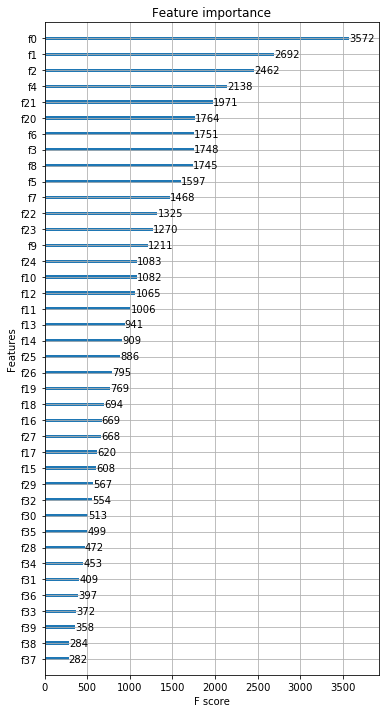

In [27]:
fig, ax = plt.subplots(1, figsize=(6, 12))
plot_importance(ax=ax, booster=clf.clf_, )
plt.show()

In [28]:
# Print cross validation results
t0 = time()
print '-'*60
print "Score on validation test (vote by majority): %f" % accuracy_score(train_labels, y_pred)
print classification_report(train_labels, y_pred, target_names=scenes)
print "Confusion matrix:"
print confusion_matrix(train_labels, y_pred)

print '-'*60
print "Score on validation test (vote by proba sum): %f" % accuracy_score(train_labels, y_pred_sum )
print classification_report(train_labels, y_pred_sum, target_names=scenes)
print "Confusion matrix:"
print confusion_matrix(train_labels, y_pred_sum)

print '-'*60
print "Score on validation test (vote by proba product): %f" % accuracy_score(train_labels, y_pred_prod)
print classification_report(train_labels, y_pred_prod, target_names=scenes)
print "Confusion matrix:"
print confusion_matrix(train_labels, y_pred_prod)
print "Done in %0.3fs." % (time()-t0)

------------------------------------------------------------
Score on validation test (vote by majority): 0.637615
                  precision    recall  f1-score   support

           beach       0.62      0.44      0.51        59
             bus       0.54      0.36      0.43        59
 cafe/restaurant       0.72      0.67      0.69        57
             car       0.95      0.88      0.91        59
     city_center       0.77      0.86      0.82        59
     forest_path       0.85      0.75      0.80        60
   grocery_store       0.80      0.86      0.83        59
            home       0.79      0.66      0.72        58
         library       0.50      0.60      0.55        58
   metro_station       0.48      0.55      0.51        56
          office       0.88      0.97      0.92        60
            park       0.41      0.29      0.34        58
residential_area       0.36      0.46      0.40        59
           train       0.42      0.27      0.33        55
            tr

In [29]:
y_test_pred = clf.predict(test_files, "maj")
y_test_pred_sum = clf.predict(test_files, "sum")
y_test_pred_prod = clf.predict(test_files, "prod")

print "Score by maj: %f" % accuracy_score(test_labels, y_test_pred)
print "Score by sum: %f" % accuracy_score(test_labels, y_test_pred_sum)
print "Score by prod: %f" % accuracy_score(test_labels, y_test_pred_prod)

#np.savetxt('y_test_pred_mfcc_qda_gs.txt', y_test_pred, fmt='%d')
#np.savetxt('y_test_pred_mfcc_qda_gs_sum.txt', y_test_pred_sum, fmt='%d')
#np.savetxt('y_test_pred_mfcc_qda_gs_prod.txt', y_pred_prod, fmt='%d')

Score by maj: 0.741611
Score by sum: 0.744966
Score by prod: 0.187919
